# Прогнозирование и обнаружение неисправностей на станках лазерной резки Навигатор КС-12В

## Препроцессинг и первичный анализ

In [1]:
"""Заполнение фичей из куска общей выборки."""

import json
from datetime import datetime

times_unix = [] # Время в Unix формате
times_datetime = [] # Отрезки времени в datetime формате

laser_temp_series = [] # Температура лазера
laser_power_series = [] # Фактическая мощность лазера
laser_set_power_series = [] # Установленная мощность лазера

with open('nav5.json') as file:
    for sample in file:
        data = json.loads(sample)
        
        timestamp = int(str(data["timestamp"])[:10])
        times_unix.append(timestamp)
        unix_converted = datetime.fromtimestamp(timestamp)
        times_datetime.append(unix_converted)
        
        laser_temp_series.append(data["laser_temp"] or 0)
        laser_power_series.append(data["laser_power"] or 0)
        laser_set_power_series.append(data["laser_set_power"] or 0)

In [2]:
"""Конвертация в numpy массив для быстрых вычислений."""

import numpy as np

times_unix = np.array(times_unix)

laser_temp_series = np.array(laser_temp_series)
laser_power_series = np.array(laser_power_series)
laser_set_power_series = np.array(laser_set_power_series)

In [3]:
"""Создание data frame для удобства манипуляции с данными."""

import pandas as pd

times_datetime = pd.DatetimeIndex(times_datetime)

df = pd.DataFrame({
    "times_datetime": times_datetime,
    "laser_temp_series": laser_temp_series,
    "laser_power_series": laser_power_series,
    "laser_set_power_series": laser_set_power_series
})

df = df.set_index(['times_datetime'])

In [4]:
"""Первичная информация."""

print("Количество строк и столбцов: ", df.shape)
print("Период временного ряда: ")
print(df.index.min())
print(df.index.max())
df.head(5)

Количество строк и столбцов:  (979582, 3)
Период временного ряда: 
2020-02-01 00:00:16
2020-06-11 21:38:58


,laser_temp_series,laser_power_series,laser_set_power_series
times_datetime,,,
2020-02-01 00:00:16,24.88667,0.00,15364.0
2020-02-01 00:00:16,24.88667,13138.08,15364.0
2020-02-01 00:00:16,25.36667,13138.08,15364.0
2020-02-01 00:00:16,25.36667,13138.08,15364.0
2020-02-01 00:00:36,25.36667,13138.08,15364.0


In [5]:
from scipy import stats

def ntest(data):
    """Проверка распределения на нормальность."""
    # stat = k^2 + s^2 -- z-scored эксцесс и ассиметрия
    stat, p = stats.normaltest(data)
    svalues = f'\nstat={stat}, p-value={p}\n'
    alpha = 0.05
    if p > alpha:
        return 'Данные похожи на нормальное распределение:'+svalues
    else:
        return 'Данные не порождены нормальным распределением:'+svalues

print("laser_temp_series")
print(ntest(df.laser_temp_series))
print("laser_power_series")
print(ntest(df.laser_power_series))

laser_temp_series
Данные не порождены нормальным распределением:
stat=460049.0790975577, p-value=0.0

laser_power_series
Данные не порождены нормальным распределением:
stat=247273.96052036807, p-value=0.0



laser_temp_series
Эксцесс (острота пика распределения): 4.319019244019009
Ассиметрия (искаженность данных): -2.4806179934401724


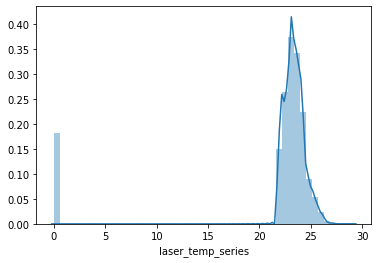

In [6]:
import seaborn as sns
sns.distplot(df.laser_temp_series);
print('laser_temp_series')
print( 'Эксцесс (острота пика распределения): {}'.format(stats.kurtosis(df.laser_temp_series)))
print( 'Ассиметрия (искаженность данных): {}'.format(stats.skew(df.laser_temp_series)))

laser_power_series
Эксцесс (острота пика распределения): 1.5045682121592465
Ассиметрия (искаженность данных): 1.5639472853029839


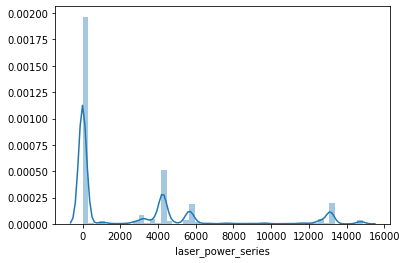

In [7]:
sns.distplot(df.laser_power_series);
print('laser_power_series')
print( 'Эксцесс (острота пика распределения): {}'.format(stats.kurtosis(df.laser_power_series)))
print( 'Ассиметрия (искаженность данных): {}'.format(stats.skew(df.laser_power_series)))

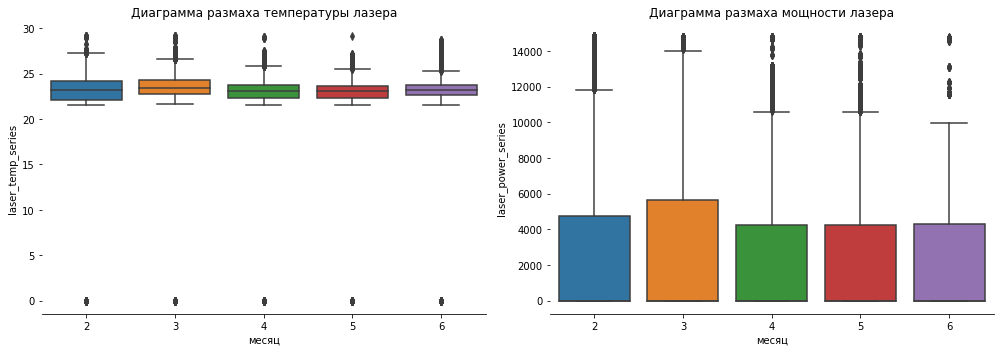

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)

sns.boxplot(x=df.index.month, y=df.laser_temp_series)
plt.xlabel('месяц')
plt.title('Диаграмма размаха температуры лазера')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1,2,2)

sns.boxplot(x=df.index.month, y=df.laser_power_series)
plt.xlabel('месяц')
plt.title('Диаграмма размаха мощности лазера')
sns.despine(left=True)
plt.tight_layout();

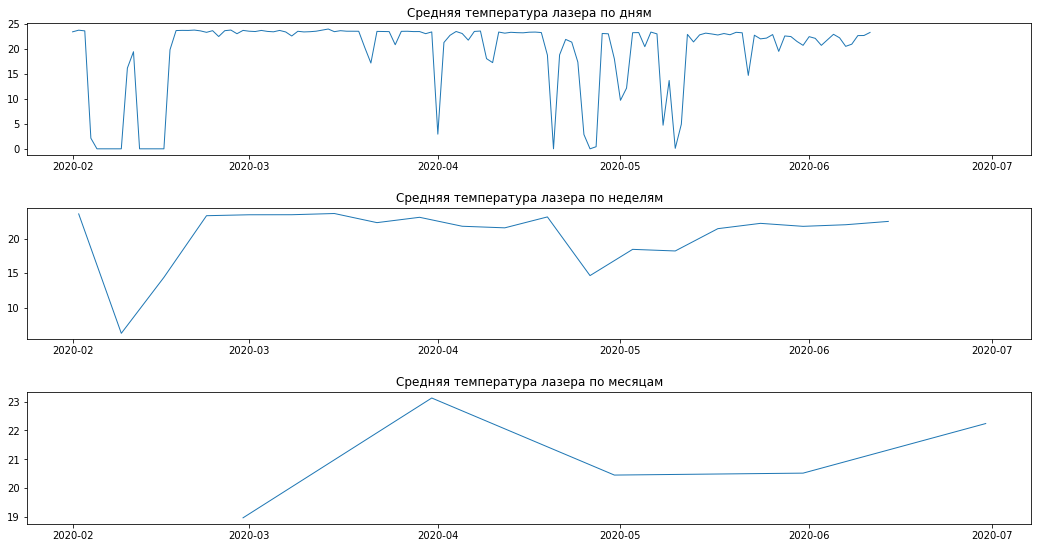

In [9]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)

ax1 = fig.add_subplot(5,1,1)
ax1.plot(df['laser_temp_series'].resample('D').mean(),linewidth=1)
ax1.set_title('Средняя температура лазера по дням')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df['laser_temp_series'].resample('W').mean(),linewidth=1)
ax2.set_title('Средняя температура лазера по неделям')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df['laser_temp_series'].resample('M').mean(),linewidth=1)
ax3.set_title('Средняя температура лазера по месяцам')
ax3.tick_params(axis='both', which='major')

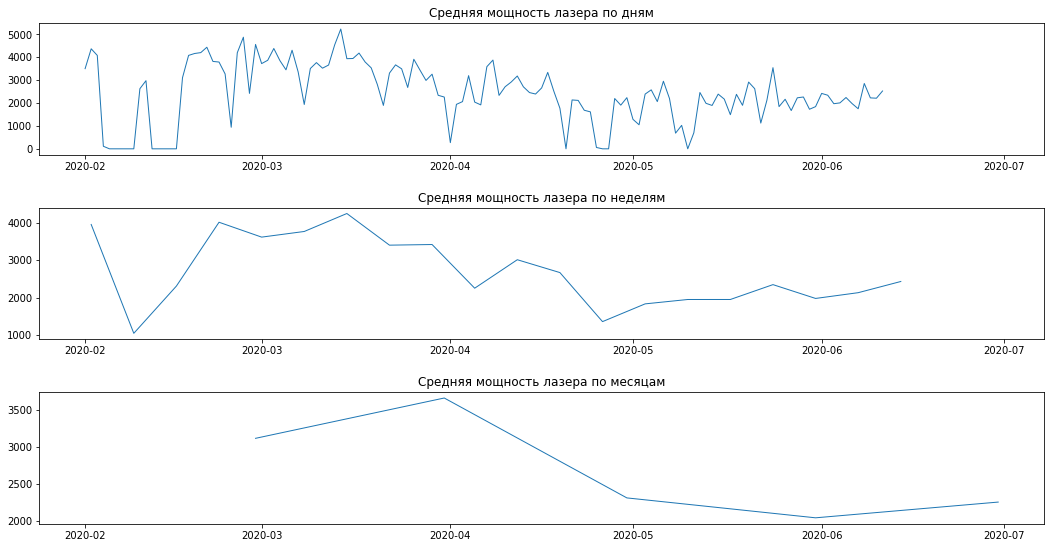

In [10]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)

ax1 = fig.add_subplot(5,1,1)
ax1.plot(df['laser_power_series'].resample('D').mean(),linewidth=1)
ax1.set_title('Средняя мощность лазера по дням')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df['laser_power_series'].resample('W').mean(),linewidth=1)
ax2.set_title('Средняя мощность лазера по неделям')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df['laser_power_series'].resample('M').mean(),linewidth=1)
ax3.set_title('Средняя мощность лазера по месяцам')
ax3.tick_params(axis='both', which='major')

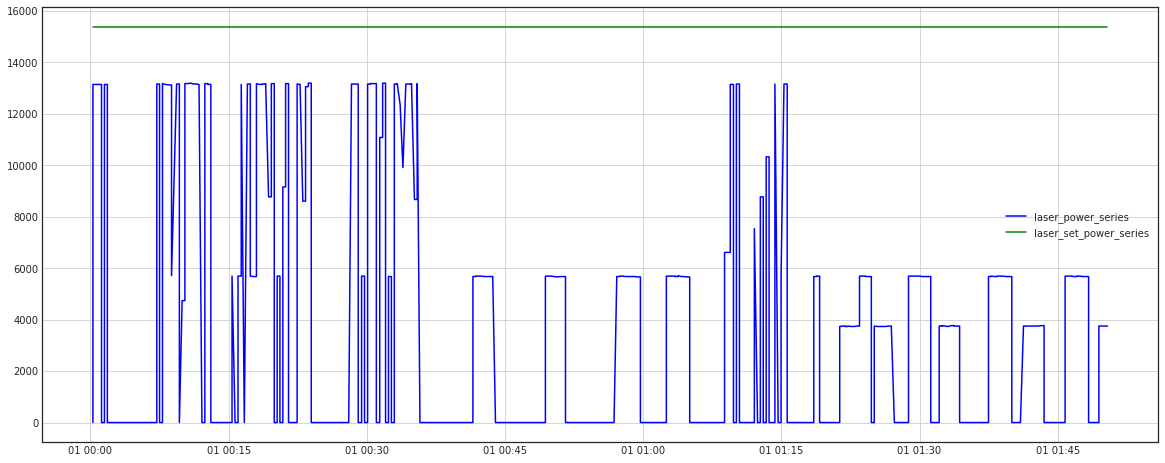

In [11]:
"""Установленная и фактическая мощность лазера."""

with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(df.laser_power_series.head(1000), "b", label="laser_power_series")
    plt.plot(df.laser_set_power_series.head(1000), "g", label="laser_set_power_series")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.grid(True)

In [12]:
def normalization(a):
    """Feature scaling."""
    return (a - np.min(a))/np.ptp(a)

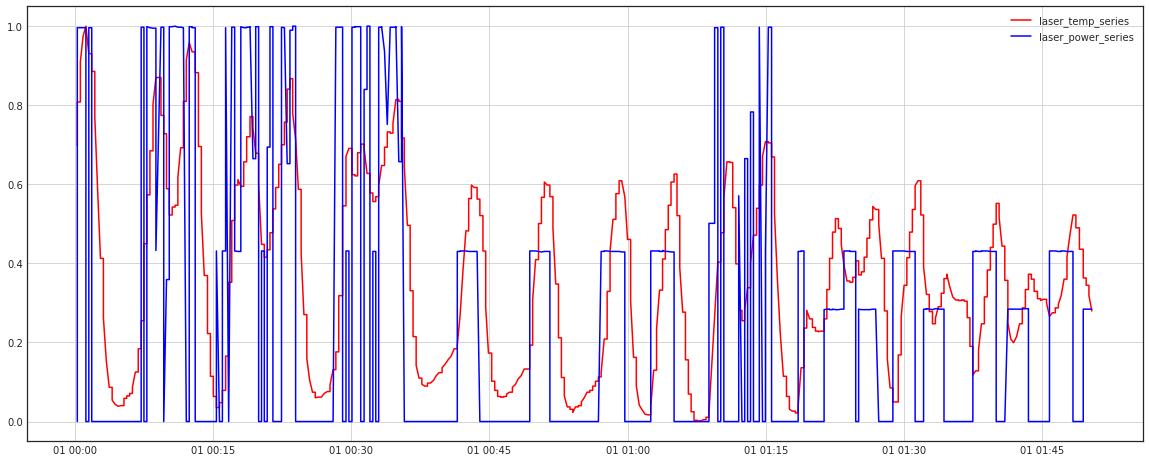

In [13]:
"""Зависимость температуры и мощности лазера."""

with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(normalization(df.laser_temp_series.head(1000)), "r", label="laser_temp_series")
    plt.plot(normalization(df.laser_power_series.head(1000)), "b", label="laser_power_series")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.grid(True)

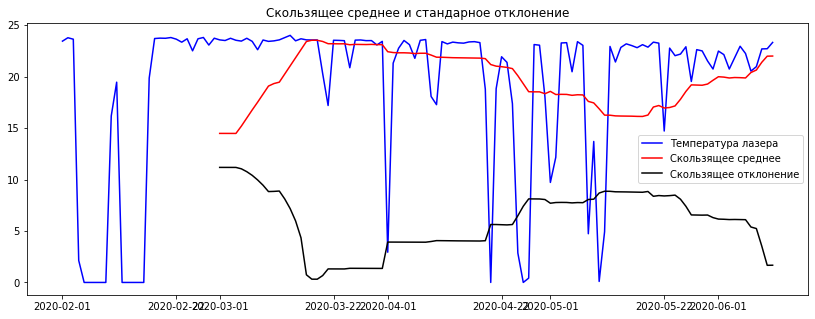

Результаты теста Дики-Фуллера
Test Statistic                  -5.048146
p-value                          0.000018
#Lags Used                       0.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64


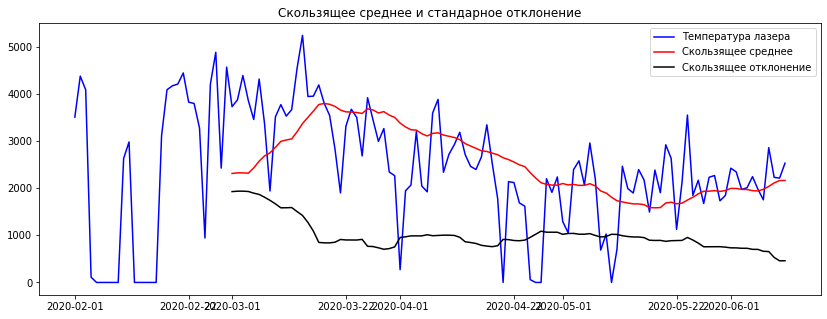

Результаты теста Дики-Фуллера
Test Statistic                  -3.688439
p-value                          0.004279
#Lags Used                       2.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


In [14]:
"""Тест Дики-Фуллера на стационарность"""

from statsmodels.tsa.stattools import adfuller

df2=df.resample('D').mean()

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Температура лазера')
    mean = plt.plot(rolmean, color='red', label='Скользящее среднее')
    std = plt.plot(rolstd, color='black', label = 'Скользящее отклонение')

    plt.legend(loc='best'); plt.title('Скользящее среднее и стандарное отклонение')
    plt.show()
    
    print ('Результаты теста Дики-Фуллера')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.laser_temp_series.dropna())
test_stationarity(df2.laser_power_series.dropna())

## Оптимальное окно обучения

Метод Ломба-Скаргл

In [32]:
import scipy.signal as signal

df_days = df.resample("H").mean()
f = np.linspace(0.01, 1, 1000)

pgram_laser_temp = signal.lombscargle(
    df.tail(1000).index, df.tail(1000).laser_temp_series, f, normalize=True)
pgram_laser_power = signal.lombscargle(
    df.tail(1000).index, df.tail(1000).laser_power_series, f, normalize=True)

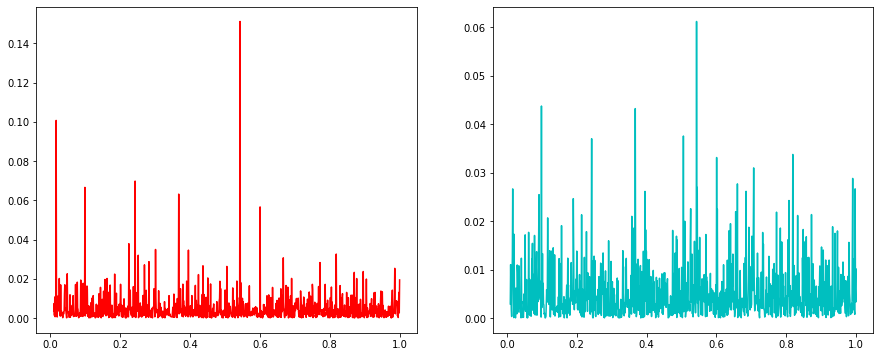

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes[0].plot(f, pgram_laser_temp,  "r", label="pgram_laser_temp")
axes[1].plot(f, pgram_laser_power, "c", label="pgram_laser_power")

## Предсказание на основе LSTM

In [61]:
"""Инициализация тренировочной и тестовой выборок."""

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

optimal_df = int(len(df.index)*0.1) # Оптимальное историческое окно
dataset = df.tail(optimal_df).laser_power_series.values # numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1)) # Featue scaling
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))



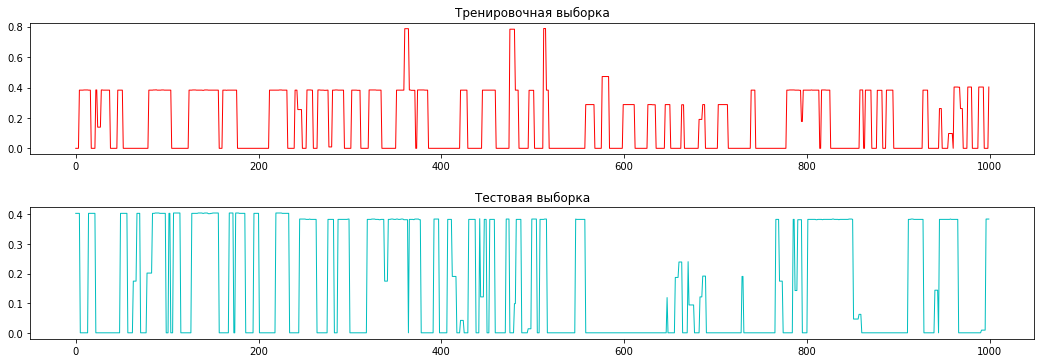

In [62]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)

ax1 = fig.add_subplot(5,1,1)
ax1.plot(train[-1000:], "r", linewidth=1)
ax1.set_title('Тренировочная выборка')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(test[:1000], "c", linewidth=1)
ax2.set_title('Тестовая выборка')
ax2.tick_params(axis='both', which='major')

In [63]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(
    X_train, Y_train,
    epochs=10, batch_size=70,
    validation_data=(X_test, Y_test), 
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
    verbose=1, shuffle=False)

model.summary()

Train on 78335 samples, validate on 19561 samples
Epoch 1/10
78335/78335 [==============================] - 3s 37us/step - loss: 0.0095 - val_loss: 0.0111
Epoch 2/10
78335/78335 [==============================] - 3s 35us/step - loss: 0.0079 - val_loss: 0.0111
Epoch 3/10
78335/78335 [==============================] - 3s 35us/step - loss: 0.0079 - val_loss: 0.0111
Epoch 4/10
78335/78335 [==============================] - 3s 36us/step - loss: 0.0078 - val_loss: 0.0111
Epoch 5/10
78335/78335 [==============================] - 3s 39us/step - loss: 0.0078 - val_loss: 0.0110
Epoch 6/10
78335/78335 [==============================] - 3s 35us/step - loss: 0.0078 - val_loss: 0.0110
Epoch 7/10
78335/78335 [==============================] - 3s 36us/step - loss: 0.0078 - val_loss: 0.0110
Epoch 8/10
78335/78335 [==============================] - 3s 36us/step - loss: 0.0077 - val_loss: 0.0109
Epoch 9/10
78335/78335 [==============================] - 3s 35us/step - loss: 0.0077 - val_loss: 0.0109
Epoch

In [64]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Тренировочная средняя абсолютная ошибка: ', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Тестовая средняя абсолютная ошибка: ', mean_absolute_error(Y_test[0], test_predict[:,0]))

Тренировочная средняя абсолютная ошибка:  702.1200454148283
Тестовая средняя абсолютная ошибка:  791.3839995582784


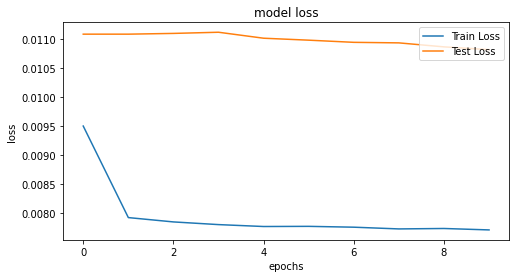

In [67]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

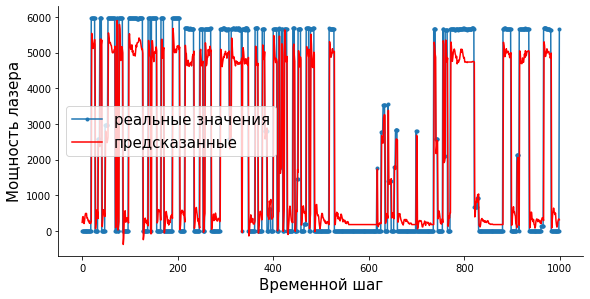

In [68]:
aa=[x for x in range(1000)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:1000], marker='.', label="реальные значения")
plt.plot(aa, test_predict[:,0][:1000], 'r', label="предсказанные")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Мощность лазера', size=15)
plt.xlabel('Временной шаг', size=15)
plt.legend(fontsize=15)
plt.show();

## Адаптивное окно предсказания

## Оптимальное количество кластеров

## Кластеризация на основе k-Shape

In [116]:
import numpy as np
from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [166]:
seed = 0
numpy.random.seed(seed)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
# Keep first 3 classes and 50 first time series
X_train = X_train[y_train < 4]
X_train = X_train[:50]
numpy.random.shuffle(X_train)
# For this method to operate properly, prior scaling is required
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
sz = X_train.shape[1]
X_train.shape

(50, 275, 1)

0.098 --> 0.089 --> 0.085 --> 0.082 --> 0.099 --> 


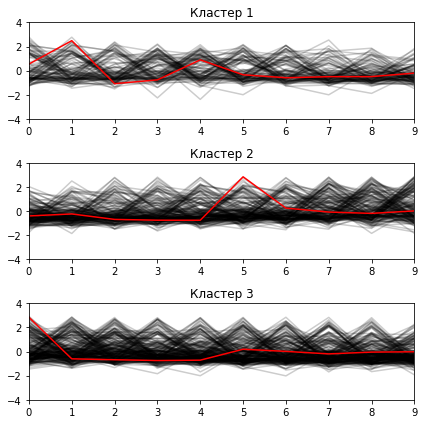

In [258]:
from tslearn.utils import to_time_series_dataset

df_tail = df.tail(1000)
temp_tail = df_tail.laser_temp_series

batch_series = []
train_size = 10
for i in range(int(len(df_tail.index)/2)):
    batch_series.append(temp_tail[i:i+train_size])

X_train = to_time_series_dataset(np.array(batch_series))
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

sz = X_train.shape[1] - 1

num_clus = 3

# k-Shape кластеризация
ks = KShape(n_clusters=num_clus, verbose=True)
y_pred = ks.fit_predict(X_train)

# Отображение кластеров
plt.figure(figsize=(6,6))
for yi in range(num_clus):
    plt.subplot(num_clus, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Кластер %d" % (yi + 1))

plt.tight_layout()
plt.show()

## Градиентный бустинг